X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Capstone Two: Modeling

In this step of my capstone, I am going to be assessing different models (and tuning hyperparamteters) in order to find the best model I can. 

1. Import training and testing files and libraries. 
2. Quick benchmark. 
3. Machine learning
4. Hyperparameter tuning

### 1. Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import KFold

import os
from library.sb_utils import save_file

In [4]:
training = pd.read_csv('./data/training_data_feature_engineered.csv')
testing = pd.read_csv('./data/testing_data_feature_engineered.csv')
# sample_submission = pd.read_csv("./data/sample_submission.csv")

In [5]:
testing.head()

,ID,shop_id,item_id,date_block_num,item_category_id,November,2015,num_holidays,April,August,...,January,July,June,March,May,October,September,2013,2014,item_month_avg_price
0,0,5,5037,34,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1926.828388
1,1,5,5320,34,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015
2,2,5,5233,34,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,800.777500
3,3,5,5232,34,23,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,790.512923
4,4,5,5268,34,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015


In [6]:
training.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,April,August,December,February,January,...,May,November,October,September,2013,2014,2015,item_cnt_month,item_month_avg_price,num_holidays
0,0,59,22154,999.00,37,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,999.00,1
1,0,25,2552,899.00,58,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,899.00,2
2,0,25,2552,899.00,58,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,899.00,2
3,0,25,2554,1709.05,58,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,1709.05,1
4,0,25,2555,1099.00,56,0,0,0,0,1,...,0,0,0,0,1,0,0,1.0,1099.00,0


### 2. Use last months sales as a benchmark. 

In [30]:
baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_cnt_month']
train = training[baseline_features]
# Remove pandas index column
train = train.set_index('shop_id')
train.item_cnt_month = train.item_cnt_month.astype(int)
train['item_cnt_month'] = train.item_cnt_month.fillna(0).clip(0,20)
# Save train set to file
train.to_csv('simple_train.csv')

In [31]:
dataset = pd.read_csv('simple_train.csv')
trainx = dataset[['shop_id','item_id','item_category_id','date_block_num']]
trainy = dataset['item_cnt_month']

test_df = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')

# Make test_dataset pandas data frame, add category id and date block num, then convert back to numpy array and predict
merged_test = pd.merge(test_df, items, on = ['item_id'])[['shop_id','item_id','item_category_id']]
merged_test['date_block_num'] = 33
merged_test.set_index('shop_id')
print(merged_test.head(3))

model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1)
model.fit(trainx, trainy, eval_metric='rmse')
preds = model.predict(merged_test.values)

df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('simple_xgb.csv')

   shop_id  item_id  item_category_id  date_block_num
0        5     5037                19              33
1        4     5037                19              33
2        6     5037                19              33
[11:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [32]:
X_train, X_test, y_train, y_test = train_test_split(dataset[['shop_id','item_id','item_category_id','date_block_num']],dataset['item_cnt_month'], test_size=0.25, random_state=42)

In [33]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train) # eval_metric='rmse'

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [34]:
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

r2 = r2_score(y_test, y_pred)
print("R-squared score:",(r2))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:",(mse))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root mean Squared Error:",(rmse))

R-squared score: 0.8909481761942196
Mean Squared Error: 99.34504440801591
Root mean Squared Error: 9.967198423228862


In [35]:
dataset.shape

(2935843, 5)

In [36]:
merged_test.shape

(214200, 4)

In [5]:
prev_month_selector = (training['October'] == 1) & (training['2015'] == 1)
last_month = training[prev_month_selector]
groups = last_month[["shop_id", "item_id",'item_cnt_month']].groupby(by=['shop_id','item_id'])
groups = groups.agg({'item_cnt_month':'sum'}).reset_index()

In [6]:
merged = testing.merge(groups, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]] 
print(testing.shape)
print(groups.shape)
print(merged.shape)
merged.isna().sum()

(214200, 22)
(31531, 3)
(214200, 2)


ID                     0
item_cnt_month    185520
dtype: int64

In [7]:
merged.item_cnt_month = merged.item_cnt_month.fillna(0)
merged.head()
merged.shape

(214200, 2)

In [8]:
datapath = './data'
save_file(merged, 'baseline.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./data\baseline.csv"


Sumbitting this to the Kaggle competition gives me a RMSE of 4.56066, which is a bad score. However, this does give us a very rudimentary baseline. 

### 3. Machine Learning

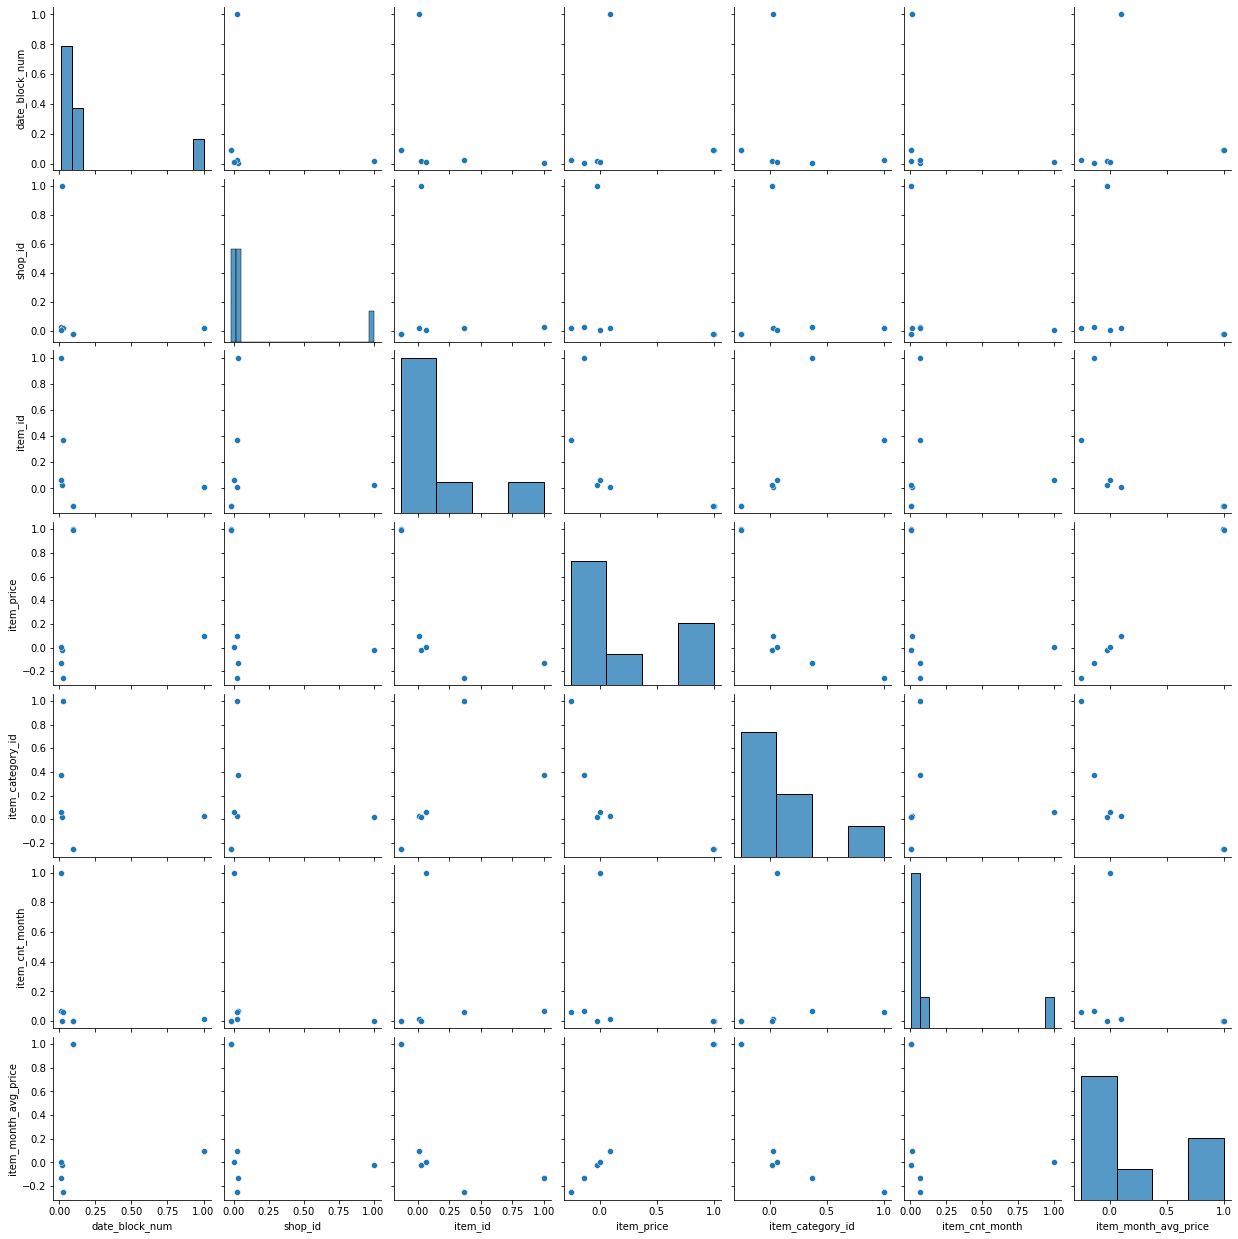

In [9]:
no_times=training.drop(['November', '2015', 'num_holidays', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'October','September', '2013', '2014'], axis=1)
sns.pairplot(no_times.corr())

<AxesSubplot:>

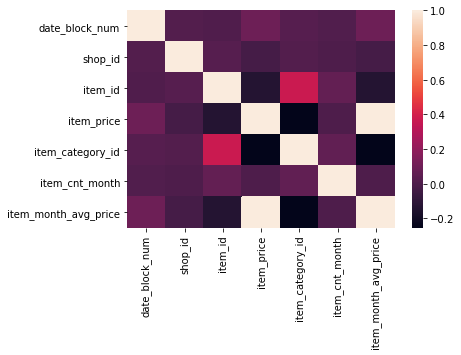

In [10]:
sns.heatmap(no_times.corr())

In [11]:
no_times.shape

(2935843, 7)

In [12]:
testing.shape

(214200, 22)

In [13]:
training.shape

(2935843, 23)

The test set consists of the cartesian product of 42 shops and 5100 items. To make a training set which approximates the test set we create a training dataframe consisting of the cartesian product (active items) x (active shops) for each month. This new dataframe, "df" is what we will use to train our machine learning algorithm.

In [14]:
from itertools import product

df = [] 
for block_num in training['date_block_num'].unique():
    cur_shops = training.loc[training['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = training.loc[training['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [15]:
columns = ['item_cnt_month','shop_id','item_id','date_block_num','item_category_id','November','2015','num_holidays','April','August','December','February','January','July','June','March','May','October','September','2013','2014','item_month_avg_price']

In [16]:
df=df.merge(training[columns], on=['shop_id','item_id','date_block_num'], how='left')

In [17]:
df.fillna(0, inplace=True)
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,November,2015,num_holidays,April,August,...,January,July,June,March,May,October,September,2013,2014,item_month_avg_price
0,59,22154,0,1.0,37.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,999.0
1,59,2552,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'item_category_id','group_name','group_id','item_category_name

In [18]:
testing.set_index("ID")

,shop_id,item_id,date_block_num,item_category_id,November,2015,num_holidays,April,August,December,...,January,July,June,March,May,October,September,2013,2014,item_month_avg_price
ID,,,,,,,,,,,,,,,,,,,,,
0,5,5037,34,19,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1926.828388
1,5,5320,34,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015
2,5,5233,34,19,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,800.777500
3,5,5232,34,23,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,790.512923
4,5,5268,34,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1026.495015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,55,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,188.681084
214196,45,16188,34,64,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1256.975000
214197,45,15757,34,55,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,198.113208


In [19]:
train_cols = df.columns.to_list()
test_cols = testing.columns.to_list()
print(list(set(train_cols).difference(test_cols)))
print(list(set(test_cols).difference(train_cols)))

['item_cnt_month']
['ID']


In [20]:
X = df.drop(['item_cnt_month'], axis=1)
y = df['item_cnt_month']

In [26]:
print(X.shape, y.shape)

(12240569, 21) (12240569,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train) # eval_metric='rmse'

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [23]:
y_pred = model.predict(X_test)

In [24]:
# predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

r2 = r2_score(y_test, y_pred)
print("R-squared score:",(r2))

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:",(mse))

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root mean Squared Error:",(rmse))

R-squared score: 0.8106641754954038
Mean Squared Error: 43.80348939171799
Root mean Squared Error: 6.618420460481337


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

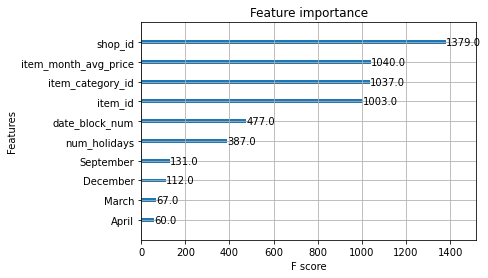

In [25]:
xgb.plot_importance(model, max_num_features = 10)

In [32]:
predictions = model.predict(testing.drop('ID', axis=1))

In [33]:
testing['item_cnt_month']=predictions

In [35]:
submission=testing[['ID','item_cnt_month']]

In [37]:
submission.shape

(214200, 2)

In [38]:
# Save the data
datapath = './data'
save_file(submission, 'first_submission.csv', datapath)

Writing file.  "./data\first_submission.csv"


This gets us a score (RMSE) of 27.59362, 12897 out of 13390. Something is clearly wrong here. 